In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import os
from joblib import dump, load

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

# Pre-processing input data

In [16]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = ["total_time"]

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [17]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Training

In [18]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

# Train
predictions_train = model.predict(X_train)
predictions_train = inv_scaling(predictions_train, y_scaler)
y_train_scaled = inv_scaling(y_train, y_scaler)
loss = np.sqrt(mean_squared_error(y_train_scaled, predictions_train))

# Test
predictions = model.predict(X_test)
predictions = inv_scaling(predictions, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
val_loss = np.sqrt(mean_squared_error(y_scaled, predictions))
print(f"RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")

RMSE Loss : 0.1628334190185127 - RMSE Val Loss: 0.1596635629644977


In [20]:
# save model
dump(model, f'../models/linear_model.joblib')

['../models/linear_model.joblib']

# Load models

In [21]:
model = load('../models/linear_model.joblib')

In [22]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}

	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [23]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [24]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 22.601422302459866 | Std actual: 40.77892012378877
Mean actual: 23.401548499932737 | Std actual: 44.0307253488359
Mean Error: 3.7057379239304016 | Std Error: 8.843459181399245
Min instance
total_time                                                            30.09
total_cpu_usage                                                        0.99
max_ram_usage                                                     62.207031
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_size                                                      256

coef: 0.9949887264667598 | intercept: 0.0016806894790497018


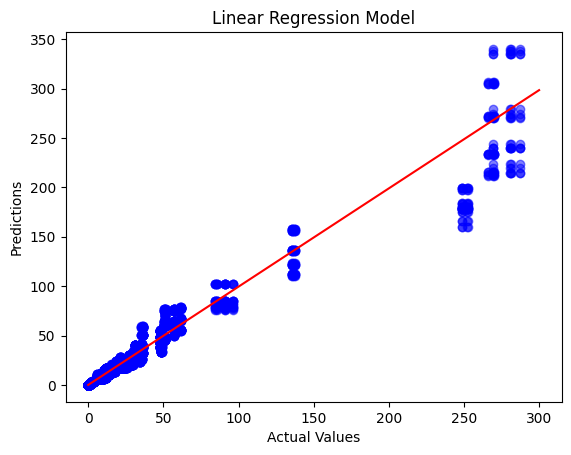

In [25]:
print("coef:",model.coef_.item(), "| intercept:",model.intercept_.item())
# Plot predictions
import matplotlib.pyplot as plt
plt.scatter(y_scaled, predictions, alpha=0.5, color='b')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model')
# Plot a line with model's parameters
x = np.linspace(0, 300, 300)
y = model.coef_.item() * x + model.intercept_.item()
plt.plot(x, y, color='r')
plt.show()

In [26]:
# get index of total_time_target < 2.00
index = test_df_og[test_df_og['total_time_target'] < 2.0].index
X_test_low = X_test[index]
y_test_low = y_test[index]
test_df_og_low = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_low, y_test_low, y_scaler)
y_scaled = inv_scaling(y_test_low, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target < 2.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_low.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_low.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target < 2.0
Mean prediction: 0.750825801685921 | Std actual: 0.5733895588584664
Mean actual: 0.500334335537253 | Std actual: 0.2995686663396718
Mean Error: 0.2618182867466495 | Std Error: 0.3098067061960038
Min instance
total_time                                                             1.89
total_cpu_usage                                                        0.99
max_ram_usage                                                     17.214844
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                          

In [27]:
# get index of 2.00 > total_time_target > 150.0
index = test_df_og[(test_df_og['total_time_target'] <= 150.0) & (test_df_og['total_time_target'] >= 2.0)].index
X_test_med = X_test[index]
y_test_med = y_test[index]
test_df_og_med = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_med, y_test_med, y_scaler)
y_scaled = inv_scaling(y_test_med, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target in [2.0, 150.0]")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_med.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_med.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target in [2.0, 150.0]
Mean prediction: 26.32625817766141 | Std actual: 23.034967445145746
Mean actual: 3.0454776818737144 | Std actual: 0.7425768880201676
Mean Error: 23.280780495787692 | Std Error: 22.41961382769956
Min instance
total_time                                                            30.09
total_cpu_usage                                                        0.99
max_ram_usage                                                     62.207031
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_size                

In [28]:
# get index of total_time_target > 150.0
index = test_df_og[test_df_og['total_time_target'] > 150.0].index
X_test_high = X_test[index]
y_test_high = y_test[index]
test_df_og_high = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_high, y_test_high, y_scaler)
y_scaled = inv_scaling(y_test_high, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target > 150.00")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_high.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_high.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target > 150.00
Mean prediction: 234.38440547182896 | Std actual: 50.637152714085154
Mean actual: 5.587667460601355 | Std actual: 0.04794298966420108
Mean Error: 228.7967380112276 | Std Error: 50.603761140712805
Min instance
total_time                                                           274.62
total_cpu_usage                                                        0.99
max_ram_usage                                                    170.035156
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                      